## Trabalho realizado por
Pedro Santos - A100110 <br><br>
João Faria - A100062

I. [Implemente o algoritmo de Grover para encontrar uma solução para o problema](#1) <p>
   1. [Sudoku na programação quântica](#sudoku) <p>
   2. [Algoritmo de Grover](#grover) <p>
      a.  [Oracle](#oracle) <p>
      b.  [Amplificação da amplitude](#amp) <p>
   3. [Remoção da ancilla](#ancilla) <p>
   4. [Código](#code) <p>
      a.  [Inicialização do PennyLane](#qml) <p>
      b.  [Variáveis iniciais](#vars) <p>
      c.  [Código com algoritmo de Grover](#grovercode) <p>
      d.  [Algoritmo visualizado](#plt) <p>
      e.  [Resultado](#result) <p>

II. [Avalie a eficiência e a complexidade do algoritmo](#2) <p>

III. [Proponha uma generalização para o Sudoku 3x3 e discuta as possíveis limitações e os recursos necessários](#3) <p>

# I. Implement Grover’s algorithm to find a solution to the problem <a id="1"></a>

## 1. Sudoku na programação quântica <a id="sudoku"></a>

O exercício que escolhemos foi o exercício 2, relacionado ao Sudoku 2x2. <br><br>
Com base nas regras do enunciado e pelo fato de ser binário, as únicas duas opções possíveis são as seguintes:

<center><div>
<img src="imgs/sudoku1.png" width="500"/>
<img src="imgs/sudoku2.png" width="500"/>
</div></center>

Com isto, podemos utilizar o algoritmo de Grover, que identifica as soluções corretas, sendo elas $|0110\rangle$ e $|1001\rangle$. <br> <br>
Vamos, então, explicar como o algoritmo de Grover funciona.

## 2. Algoritmo de Grover <a id="grover"></a>

### a. Oracle <a id="oracle"></a>

O oracle é implementado como uma operação quântica que inverte a fase dos estados que correspondem às soluções desejadas, enquanto deixa os outros estados inalterados. <br><br>
Sendo assim, temos a seguinte equacao:

$$
U_\omega|x\rangle = \bigg\{
\begin{aligned}
\phantom{-}|x\rangle \quad \text{se} \; x \notin \{ |0110\rangle, |1001\rangle \} \\
-|x\rangle \quad \text{se} \; x \in \{ |0110\rangle, |1001\rangle \} \\
\end{aligned}
$$

Agora é necessario amplificar a probabilidade dos estados que queremos.

### b. Amplificação da amplitude <a id="amp"></a>


A amplificação da amplitude é um processo que calcula a média de todas as soluções. <br><br>
Como as soluções corretas possuem sinais negativos, ao calcular a média, ocorre um aumento nas probabilidades associadas às soluções desejadas.
Esse processo pode ser representado pela seguinte equação:

$$D = 2|DB \rangle \langle DB| - I$$

Onde $|DB\rangle$ é o estado quântico da superposição dos dados e D é  a amplificação da amplitude das soluções.

Com isso, basta repetir este processo até que as múltiplas soluções desejadas atinjam as probabilidades máximas possíveis ($\frac{\pi}{4} \sqrt{\frac{N^2}{M}}$). <br><br>
$N$ sendo o total de qubits e $M$ sendo o total de estados possíveis.

## 3. Remoção da ancilla <a id="ancilla"></a>

A ancilla era usada originalmente para implementar o operador de fase (oracle) e amplificação de amplitude, mas isso pode ser feito diretamente nos qubits de entrada usando operações controladas (ControlledQubitUnitary) com a matriz Z, que permite aplicar o que o CNOT faria com uma ancilla diretamente no último qubit. <br><br>
A matriz Z faz exatamente o que o oracle do algoritmo de Grover precisa fazer. O oracle deve marcar as soluções adicionando uma fase de -1, e o Pauli-Z faz isso de forma natural:<br><br>
Para um estado |x⟩, o Pauli-Z age como:
$$ Z|0\rangle = |0\rangle$$
$$ Z|1\rangle = -|1\rangle $$

## 4. Código <a id="code"></a>

Para aplicar este algoritmo iremos usar pennylane na versão 0.40.0. <br><br>
Nota: A função qml.broadcast parece ter sido descontinuada nesta versão. Por isso, utilizamos funções auxiliares (broadcast_X e broadcast_H) que replicam o comportamento que o broadcast teria.

### a. Inicialização do PennyLane <a id="qml"></a>

(Impressão da versão do PennyLane para haver esclarecimento da compatibilidade do código.)

In [ ]:
import pennylane as qml
from pennylane import numpy as np

print(qml.__version__)

0.40.0


### b. Variáveis iniciais <a id="vars"></a>

Como mencionado anteriormente, serão necessários 4 qubits com as soluções $|0110\rangle$ e $|1001\rangle$.

In [ ]:
n_qubits = 4
ids = [[0,1,1,0],[1,0,0,1]]

dev = qml.device("default.qubit", wires=n_qubits+1)

### c. Código com algoritmo de Grover <a id="grovercode"></a>

In [ ]:
# qml.broadcast deixou de existir na 0.40.0
def broadcast_X(list):
    for i in list:
        qml.PauliX(wires=i)

def broadcast_H(list):
    for i in list:
        qml.Hadamard(wires=i)

@qml.qnode(dev)
def grover(n_qubits, ids, its="optimal"):

    #create registers
    input_registers = range(n_qubits)

    #superposition
    broadcast_H(input_registers)

    qml.Barrier()

    if its == "optimal":
        its = round(np.pi/4*np.sqrt(2**n_qubits/len(ids)) - 0.5)

    for _ in range(its):

        #oracle
        for id in ids:
            broadcast_X(input_registers[i] for (i,k) in enumerate(id) if k == 0)
            qml.ControlledQubitUnitary(qml.PauliZ(input_registers[-1]), control_wires=input_registers[:-1])
            broadcast_X(input_registers[i] for (i,k) in enumerate(id) if k == 0)

        qml.Barrier()

        #diffusion
        broadcast_H(input_registers)
        broadcast_X(input_registers)
        qml.ControlledQubitUnitary(qml.PauliZ(input_registers[-1]), control_wires=input_registers[:-1])
        broadcast_X(input_registers)
        broadcast_H(input_registers)

        qml.Barrier()

    #measurement
    return qml.probs(wires=input_registers)

### d. Algoritmo visualizado <a id="plt"></a>

(<Figure size 2900x500 with 1 Axes>, <Axes: >)

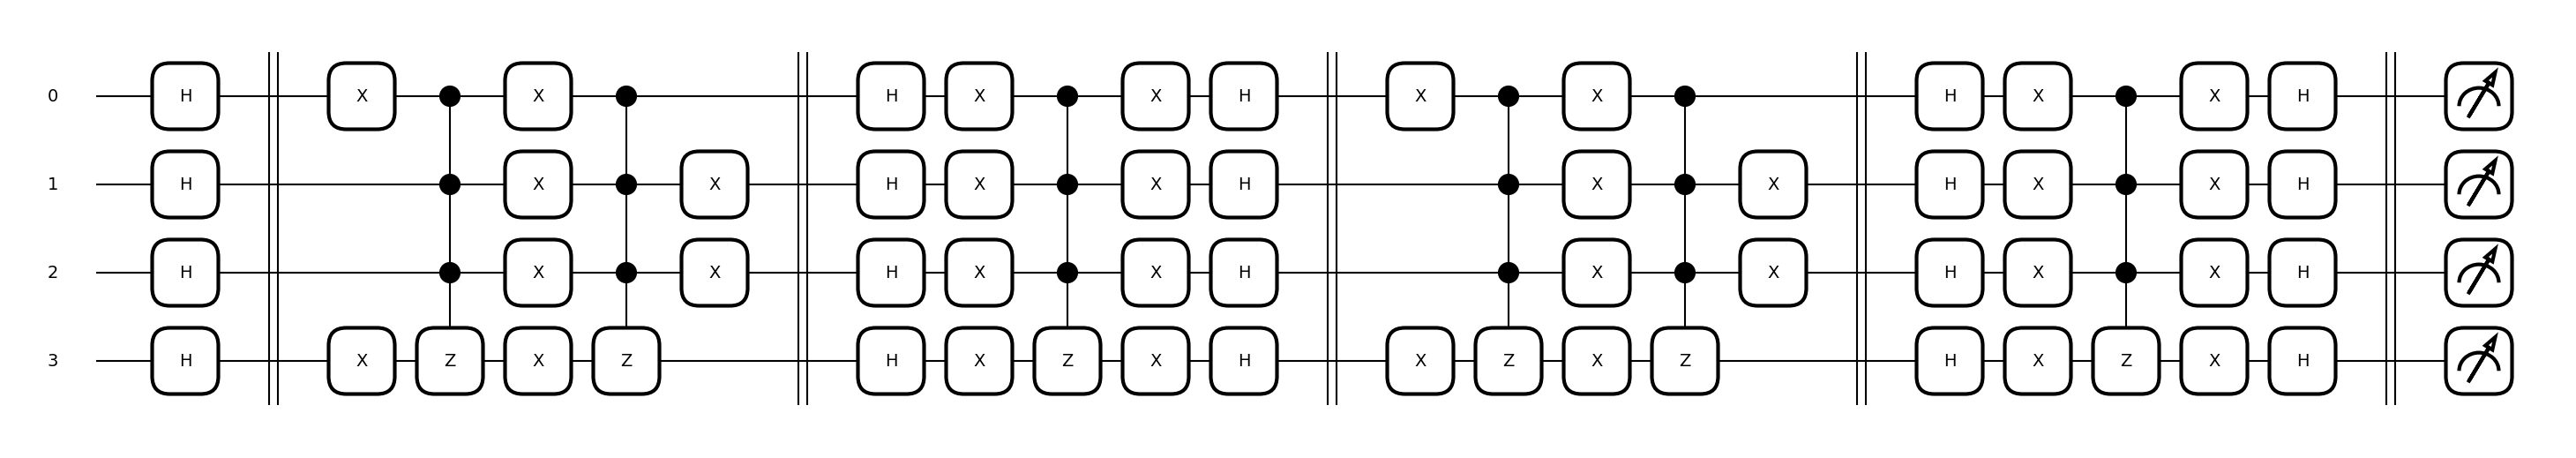

In [ ]:
Grover = qml.QNode(grover, dev)

probs = Grover(n_qubits, ids)

qml.draw_mpl(Grover)(n_qubits, ids)

### e. Resultado <a id="result"></a>

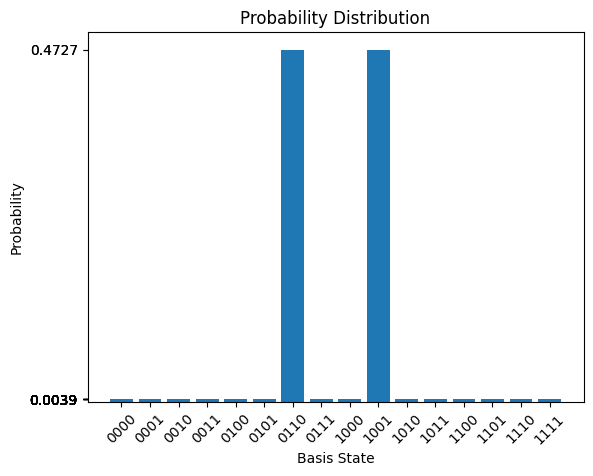

In [ ]:
#Visualize the probability histogram
import matplotlib.pyplot as plt
plt.bar([np.binary_repr(i, width=n_qubits) for i in range(2**n_qubits)], probs)

plt.xlabel("Basis State")
plt.ylabel("Probability")
plt.yticks(probs)
plt.title("Probability Distribution")

plt.xticks(rotation=45)

plt.show()

# II. Avalie a eficiência e a complexidade do algoritmo <a id="2"></a>

A complexidade do Algoritmo é dada por sqrt(N) para N soluções do problema,neste caso como o sudoku é 2x2 o algoritmo de grover consegue resolver com facilidade,pois são apenas necessarios 4 qubits.

# III. Proponha uma generalização para o Sudoku 3x3 e discuta as possíveis limitações e os recursos necessários <a id="3"></a>

Já no sudoku 3x3 seriam necessarios mais qubits,visto que são 9 celulas em que cada uma pode ter valores de 1-9.